# Library

In [27]:
!pip install missingno

ERROR: Could not find a version that satisfies the requirement platform (from versions: none)
ERROR: No matching distribution found for platform


In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Auto reload of library
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from itertools import product, permutations, combinations # iterative combinations
import missingno as msno

## 한글 이슈
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
global FONT_NAME
global FONT_PATHS
from matplotlib import font_manager, rc
FONT_NAME = 'Malgun Gothic'
# FONT_NAME = 'malgun'
plt.rc('font', family=FONT_NAME) 
plt.rcParams['font.family'] = FONT_NAME
mpl.rc('font', family=FONT_NAME)
sns.set(font=FONT_NAME) 
sys_font = font_manager.findSystemFonts()
FONT_PATHS = [path for path in sys_font if 'malgun' in path]
if len(FONT_PATHS) != 0:
    rc('font', family=font_manager.FontProperties(fname=FONT_PATHS[0]).get_name())

mpl.rc('axes', unicode_minus=False)
plt.rc('axes', unicode_minus=False)
sns.set(rc={"axes.unicode_minus":False}, style='white')

In [3]:
### Date and Author: 20241202, Kyungwon Kim ###
### 2개의 df 변수명 비교
def table_compare_2dfcolname(df_left, df_right):
    # 세팅
    df_left_col, df_right_col = df_left.columns, df_right.columns
    
    df_col = []
    for coll, colr in list(itertools.zip_longest(df_left_col, df_right_col)):
        # 왼쪽만 존재하는 값 처리
        if coll not in df_right_col:
            df_col.append((coll, 0))
        # 오른쪽만 존재하는 값 처리
        if colr not in df_left_col:
            df_col.append((0, colr))
        # 공통으로 존재하는 값 처리
        if coll in df_right_col:
            df_col.append((coll, coll))
        elif colr in df_left_col:
            df_col.append((colr, colr))

    # 중복제거 및 결측값처리
    df_col = pd.DataFrame(df_col).drop_duplicates(keep='first')
    df_col.dropna(inplace=True)
    df_col.columns = ['Left', 'Right']
        
    return df_col.reset_index().iloc[:,1:]


### Date and Author: 20241204, Kyungwon Kim ###
### 2개의 df 변수명 비교결과를 사용하여 추가 데이터 붙이기
### example
# colname_compare, colname_common = table_compare_dfscolname(df_dict[2023], [df_dict[2021], df_dict[2019], df_dict[2017], df_dict[2015]],
#                                                            colname_list=[2023, 2021, 2019, 2017, 2015])
def table_compare_dfscolname(df_left, df_right_list, colname_list=None):
    for idx, df_right in tqdm(enumerate(df_right_list)):
        if idx == 0:
            df_compare = table_compare_2dfcolname(df_left, df_right)
        else:
            # df_compare의 독립 변수명들을 붙여 1개로 만듬
            col_temp = []
            for i in df_compare.values:
                if len(set(i)) == 1:
                    col_temp.append(i[0])
                else:
                    col_temp.append([i for i in set(i) if i != 0][0])

            ## 신규 DB와의 변수 비교
            df_left = pd.DataFrame(col_temp).set_index(0).T
            df_concat = table_compare_2dfcolname(df_left, df_right)

            # df_compare 업데이트
            df_new = []
            for val in df_concat.Left:
                if val != 0:
                    df_new.append([list(i) for i in df_compare.values if val in i][0])
                else:
                    df_new.append([0]*df_compare.shape[1])
            df_new = pd.DataFrame(df_new)
            df_new.columns = df_compare.columns

            # 신규 DB 변수 비교결과 붙이기
            df_new = pd.concat([df_new, df_concat.iloc[:,-1:]], axis=1)
            df_compare = df_new.copy()
    
    # 컬럼명 정리
    if colname_list == None:
        df_new.columns = ['Features_DB'+str(i+1) for i in range(len(df_right_list)+1)]
    else:
        df_new.columns = ['Features_'+str(i) for i in colname_list]
    colname_compare = df_new.reset_index().iloc[:,1:]
    colname_common = colname_compare[(colname_compare == 0).sum(axis=1) <= len(colname_compare.columns)*0.5]
    
    return colname_compare, colname_common


### Date and Author: 20241204, Kyungwon Kim ###
### Transfer Concatenated Dataframe from Dict
def dict_to_concatdf(df_dict):
    df_concat = pd.DataFrame()
    for key in df_dict.keys():
        df_dict[key]['Key'] = key
        df_concat = pd.concat([df_concat, df_dict[key]], axis=0)
    
    return df_concat.reset_index().iloc[:,1:]

# Hyperparameters

In [4]:
# 하이퍼파라미터
DF_YEAR = [2022, 2021, 2020, 2019, 2018]
Y_colname = None
X_dummy = None
X_reverse = None
TEST_SIZE = 0.2
RANDOM_STATE = 123
CLASS_STAT = True
SAMPLING_METHOD = 'RandomUnderSampler'
SAMPLING_STRATEGY = 'auto'
SCALER = 'minmax'
# LABEL_LIST = ['Non-donation', 'Donation']

# Data Merge

In [5]:
# 데이터 로딩
df_dict = dict()
df_columns = pd.read_excel(os.path.join('.', 'Data', '평생교육실태조사_코드명통합_수정본.xlsx')).iloc[:,2:]
for year in DF_YEAR:
    folder_location=os.path.join('.', 'Data', '{}_총괄_20250320_36011.csv'.format(year))
    df_dict[year] = pd.read_csv(folder_location, encoding='cp949')
    print(year, df_dict[year].shape)
    ## 변수명 DF_YEAR[0]기준으로 동일하게 변경
    if year != DF_YEAR[0]:
        df_sub = pd.concat([df_columns[[col for col in df_columns.columns if col.split('_')[1] == str(year)]], df_columns.iloc[:,[0]]], axis=1)
        df_rename = dict(df_sub[df_sub.iloc[:,1] != 0].dropna().reset_index().iloc[:,1:].values)
        df_dict[year] = df_dict[year].rename(columns=df_rename)
      
# 변수명 비교
colname_compare, colname_common = table_compare_dfscolname(df_dict[DF_YEAR[0]], [df_dict[i] for i in DF_YEAR[1:]],
                                                           colname_list=DF_YEAR)

## 최종변수 정리
for year in DF_YEAR:
    ## 사용할 변수명 추출
    colnames = list(colname_common[[i for i in colname_common.columns if i.split('_')[1] == str(year)]].values.flatten())
    
    ## 최종선택과 추가해야할 변수 구분
    colname_select, colname_add = [], []
    for idx, colname in enumerate(colnames):
        if colname != 0:
            colname_select.append(colname)
        else:
            colname_add.append([i for i in colname_common.iloc[idx,:].unique() if i != 0][0])
            
    ## 변수 업데이트
    df_dict[year] = df_dict[year][colname_select]
    for add in colname_add:
        df_dict[year][add] = np.nan

## df 생성
df = dict_to_concatdf(df_dict)

2022 (9968, 497)
2021 (9905, 454)
2020 (9776, 434)
2019 (9973, 511)
2018 (11747, 600)


4it [00:06,  1.59s/it]


<Axes: >

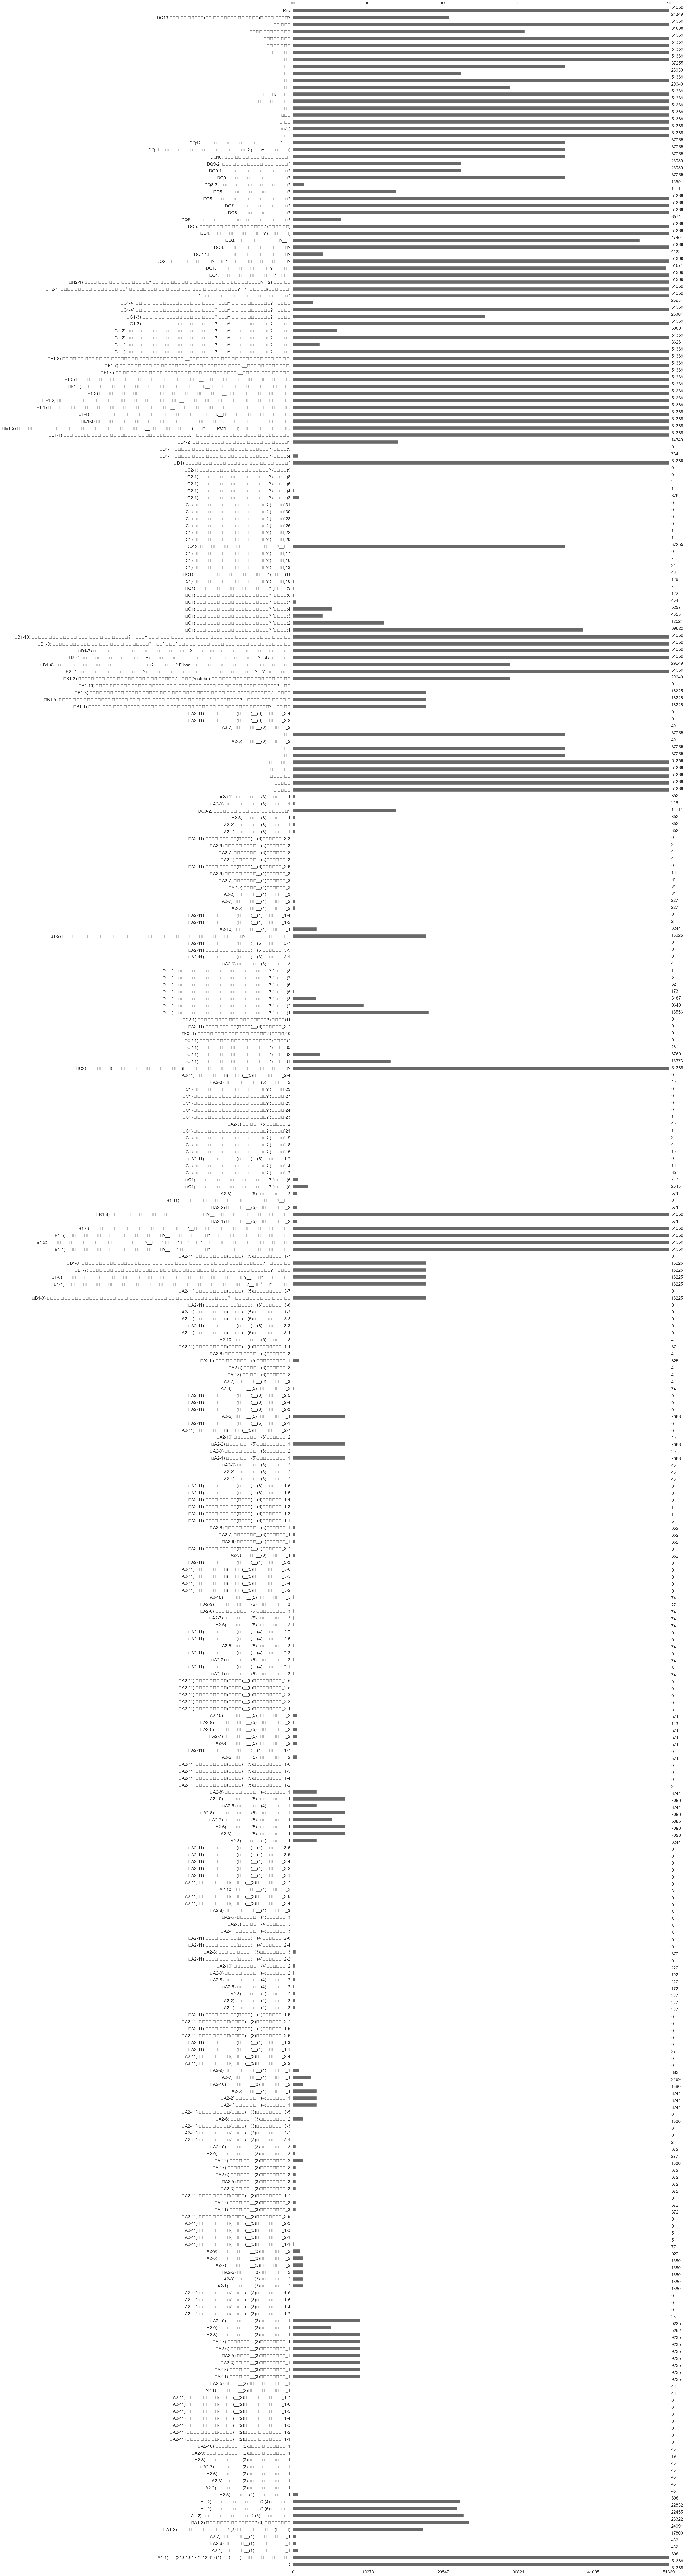

In [6]:
# 결측치 확인
msno.bar(df)

In [12]:
# 저장
colname_compare.to_csv('df_column_compare.csv', encoding='utf-8-sig') 
colname_common.to_csv('df_column_common.csv', encoding='utf-8-sig')
df.to_csv('df_concat.csv', encoding='utf-8-sig')